In [6]:
import tensorflow as tf
import numpy
import scipy.io
from tensorflow.python.client import timeline
import time

sessione = tf.Session()

# CARICO DATI

tFft = 8192#4096#8192
tObs = 9 #mesi
tObs = tObs*30*24*60*60
nPunti = 3
cands = 10

percorsoDati = "/home/protoss/Documenti/TESI/DATI/dati9mesi52HWI.mat"
#percorsoDati = "/home/protoss/Documenti/TESI/DATI/datiunmese.mat"
percorsoQuad = ("/home/protoss/Documenti/TESI/thesis/codici/matlabbo/quad%d.mat" % tFft)
percorsoPatch = ("/home/protoss/Documenti/TESI/thesis/codici/matlabbo/quad%dEclNew.mat" % tFft)

#percorsoQuad = "/home/protoss/Documenti/TESI/thesis/codici/matlabbo/quadHWI52.mat"
#percorsoPatch = "/home/protoss/Documenti/TESI/thesis/codici/matlabbo/quadHWI52Ecl.mat"



#carico file dati
quadrato = scipy.io.loadmat(percorsoQuad)['quad'].astype(numpy.float32)
patch = scipy.io.loadmat(percorsoPatch)['quadratoEclNew'].astype(numpy.float32)

struttura = scipy.io.loadmat(percorsoDati)['job_pack_0']
tempi = struttura['peaks'][0,0][0].astype(numpy.float32)
frequenze = struttura['peaks'][0,0][1].astype(numpy.float32)
pesi = (struttura['peaks'][0,0][4]+1).astype(numpy.float32)



#nb: picchi ha 0-tempi
#              1-frequenze
#              2-pesi

#headers vari
securbelt = 4000
#securbelt = 4000*3

#frequenze
stepFreq = 1/tFft
enhancement = 10
stepFreqRaffinato =  stepFreq/enhancement
nstepsFreq = securbelt+(numpy.amax(frequenze)-numpy.amin(frequenze) + stepFreq + 2*stepFreqRaffinato)/stepFreqRaffinato


#tempi
#epoca definita come mediana di tempi di tutto il run #WARNING da ridefinire con durata dati che prendo
epoca = (57722+57874)/2

#spindowns
spindownMin = -1e-9
spindownMax = 1e-10
stepSpindown = stepFreq/tObs 

nstepSpindown = numpy.round((spindownMax-spindownMin)/stepSpindown).astype(numpy.int32)
spindowns = numpy.arange(0, nstepSpindown)
spindowns = numpy.multiply(spindowns,stepSpindown)
spindowns = numpy.add(spindowns, spindownMin)

indice0 = numpy.where(spindowns>0)[0][0]-1

spindowns = spindowns-spindowns[indice0]
#LO STEP DI SPINDOWN LO SI DEFINISCE TRAMITE LA BANDA IN FREQUENZA DELLA PEAKMAP (in hz) 
#SU TEMPO DI OSSERVAZIONE (in sec):
#STEPFREQ/TOBS! DA QUI SCEGLIAMO QUALE SD MASSIMO E MINIMO TENERE

# COME VALORE MASSIMO TENERE SUI 1*-10^-9
# COME MASSIMO ANCHE CIRCA 1*+10^-10
# CONSIDERARE EVENTUALE SORGENTE NELLA SCELTA DI INTERVALLO SPINDOWN

#per doppler corr
veloc = struttura['basic_info'][0,0]['velpos'][0,0][0:3,:].astype(numpy.float32)
nTempi = struttura['basic_info'][0,0]['ntim'][0,0][0,0]
primoTempo = struttura['basic_info'][0,0]['tim0'][0,0][0,0]
indices = struttura['basic_info'][0,0]['index'][0,0][0]

In [5]:
# calcola la correzione doppler per ogni punto del cielo
def doppCorr(i):
    
    quadratoNP = quadrato[i]
    indicesOpt = indices-1
    inizi = indicesOpt[:-1]
    fini = indicesOpt[1:]

    
    velocitas = numpy.zeros((3,frequenze.size))
    for i in numpy.arange(0,nTempi-1):
        velocitas[:,inizi[i]:fini[i]+1] = veloc[:,i:i+1]
    velPerPosIndex = numpy.dot(quadratoNP,velocitas)
    divisoreIndex = 1+velPerPosIndex
    freqCorr = frequenze / divisoreIndex

    
    freqMin = numpy.amin(freqCorr)
    #freqMax = tf.reduce_max(freqCorr)
    freqIniz = freqMin- stepFreq/2 - stepFreqRaffinato
    #freqFin = freqMax + stepFreq/2 + stepFreqRaffinato
    #nstepFrequenze = tf.ceil((freqFin-freqIniz)/stepFreqRaffinato)+securbelt

    # riarrangio gli array in modo che abbia i dati 
    # nel formato che voglio io
    
    return freqIniz, freqCorr#freqCorr#, nstepFrequenze

In [7]:
#SPLITTO DOPP CORR E HOUGH TRANS

# PREPARO FUNZIONI

#TODO STUDIARE FATTIBILITÀ DI USARE TUTTO A 32BYTES

# calcola la correzione doppler per ogni punto del cielo
def doppcorr(i):
    #qui faccio la doppl corr
    velPerPos = tf.matmul(tf.reshape(quadTF[i], [1,3]),velTF)
    velPerPos = velPerPos + 1
    velPerPos = velPerPos[0]
    
    # qui va messa parte per calcolare i pesi, che per ora non mettiamo
    
    # e quindi definisco un nuovo array di velocità con i soli i valori
    # che mi interessano
    velUtili = tf.gather(velPerPos, indiciVel)

    #infine faccio la divisione e quindi ho le frequenze corrette
    freqCorr = freqTF/tf.gather_nd(velUtili,indiciUniciRipetuti[:,None])
    
    #mi ricavo l'header per le frequenze
    freqMin = tf.reduce_min(freqCorr)
    #freqMax = tf.reduce_max(freqCorr)
    freqIniz = freqMin- stepFreq/2 - stepFreqRaffinato
    #freqFin = freqMax + stepFreq/2 + stepFreqRaffinato
    #nstepFrequenze = tf.ceil((freqFin-freqIniz)/stepFreqRaffinato)+securbelt

    # riarrangio gli array in modo che abbia i dati 
    # nel formato che voglio io
    freqCorr = freqCorr-freqIniz
    freqCorr = (freqCorr/stepFreqRaffinato)-round(enhancement/2+0.001)
    freqCorr = tf.cast(freqCorr, tf.float32)
    
    freqIniz = tf.cast(freqIniz, tf.float32)
    
    freqs = tf.concat([[freqIniz], freqCorr], 0)
    
    return freqs#freqCorr#, nstepFrequenze

# calcola la hough per ogni punto del cielo (per ogni spindown)
def inDaHough(i):
    #calcola la hough per ogni step di spindown
    #WARNING per ora la metto qui perché non so come si passano variabili non iterabili con tf.map
    def houghizza(stepIesimo):
        sdTimed = tf.multiply(spindownsTF[stepIesimo], tempiHM, name = "Tdotpert")
        #sdTimed = tf.cast(sdTimed, dtype=tf.float32)
    
        appoggio = tf.round(freqHM-sdTimed+securbelt/2, name = "appoggioperindici")
        appoggio = tf.cast(appoggio, dtype=tf.int32)
        
        valorisx = tf.unsorted_segment_sum(pesiHM, appoggio, nColumns)
        return valorisx
    #un po' di manipolazioni per il calcolo della hough
    
    freq = freqTF[i]
    freqHM = freq[1:tf.size(freq)]
    freqIn = freq[0]
    
    # faccio la hough (differenziale)
    houghDiff = tf.map_fn(houghizza, tf.range(0, nRows), dtype=tf.float32, parallel_iterations=8)

    def sliceInt():
        #faccio integrazione finale (vecchia versione senza conv)
        semiLarghezza = tf.round(enhancement/2+0.001)
        semiLarghezza = tf.cast(semiLarghezza, tf.int32)
        houghInt = houghDiff[:,enhancement:nColumns]-houghDiff[:,0:nColumns - enhancement]
        houghInt = tf.concat([houghDiff[:,0:enhancement],houghInt],1)
        return houghInt
    
    #def convInt():
    #    #faccio integrazione finale (nuova versione con conv)
    #    kernel = tf.concat(([-1.0],tf.zeros(enhancement-2,dtype=tf.float32),[1.0]),0)
    #
    #    houghConv = tf.reshape(houghDiff,(1,nRows,nColumns,1))
    #    kernel = tf.reshape(kernel, (1,enhancement,1,1))
    #
    #    houghInt = tf.nn.conv2d(input=houghConv,filter=kernel,strides=[1,1,1,1],padding ='VALID')
    #    houghInt = tf.reshape(houghInt, (nRows,nColumns-(enhancement-1)))
        #houghInt = tf.nn.conv2d(input=houghDiff,filter=kernel,strides=[1,1,1,1],padding ='SAME')
        #houghInt = tf.reshape(houghInt, (nRows,nColumns))
        #CONTROLLARE SE CI SONO DIFFERENZE
        #TESTARE SE CON MATRICI DI 8-9 MESI CI METTE DI MENO CHE CON SLICE!
    #    return houghInt
    
    
    
    hough = sliceInt()
    #hough = convInt()
    houghinal = tf.cumsum(hough, axis = 1)
    
    return houghinal, freqIn
    #return houghDiff
    
    
def manchurian_candidates(numCand, freqIniz, image, coord):
    minDistance = enhancement*4

    candidati = numpy.zeros((9,numCand*2))

    primaFreq = freqIniz-(securbelt/2)*stepFreqRaffinato

    freqIniziale = struttura['basic_info'][0,0]['frin'][0,0][0,0]
    freqFinale = struttura['basic_info'][0,0]['frfi'][0,0][0,0]
    
    #QUI ANALOGO FUNZIONE CUT GD2
    #%time indexInizialewh = numpy.where(freqniu>freqIniziale)[0][0]
    #%time indexFinalewh = numpy.where(freqniu>freqFinale)[0][0]
    start = time.time()

    indexIniziale = ((freqIniziale-primaFreq)/stepFreqRaffinato).astype(numpy.int64)
    indexFinale = ((freqFinale-primaFreq)/stepFreqRaffinato+1).astype(numpy.int64)

    imageCand = image[:,indexIniziale:indexFinale]

    size = numpy.shape(imageCand)[1]
    freqniu = numpy.arange(0,size)*stepFreqRaffinato+freqIniziale

    maxPerColumn = numpy.amax(imageCand, axis = 0)
    rigaMax = numpy.argmax(imageCand, axis = 0)

    #######################

    stepFrequenzaNiu = maxPerColumn.size/numCand

    indiciFreq = numpy.arange(0,maxPerColumn.size,stepFrequenzaNiu)
    indiciFreq = numpy.append(indiciFreq, maxPerColumn.size)
    indiciFreq = numpy.round(indiciFreq).astype(numpy.int64)

    def statistics(ndArray):
        #ndArray = numpy.ravel(ndArray)
        mediana = numpy.median(ndArray)
        sigmana = numpy.median(numpy.absolute(ndArray-mediana))/0.6745
        return mediana, sigmana

    stats = statistics(imageCand)
    medianaTot = stats[0]

    iniziali = numpy.concatenate(([indiciFreq[0]],indiciFreq[0:numCand-2],[indiciFreq[indiciFreq.size-3]]),0)
    finali = numpy.concatenate(([indiciFreq[2]-1],indiciFreq[3:numCand+1]-1,[indiciFreq[indiciFreq.size-1]-1]),0)

    def statsPerCand(i):
        stat = statistics(maxPerColumn[iniziali[i]:finali[i]])#[0]
        return stat

    statPerCand = numpy.array(list(map(statsPerCand, numpy.arange(numCand))))
    medianaPerCand = statPerCand[:,0]
    sigmanaPerCand = statPerCand[:,1]
    
    filtro = numpy.where(medianaPerCand > 0)[0]
    #medCandFiltrata = medianaPerCand[filtro]
    counter = 0
    for i in filtro:
        inizio = indiciFreq[i]
        fine = indiciFreq[i+1]-1
        porzioneMaxPerColumn = maxPerColumn[inizio:fine]
        localMax = numpy.amax(porzioneMaxPerColumn)
        localInd = numpy.argmax(porzioneMaxPerColumn)
        if localMax > medianaPerCand[i] and localMax > medianaTot/2:
            counter = counter + 1
            index = indiciFreq[i] + localInd-1
            candidati[0,counter] = freqniu[index]
            candidati[1,counter] = coord[0]
            candidati[2,counter] = coord[1]
            riga = rigaMax[index]
            candidati[3,counter] = spindowns[riga]
            candidati[4,counter] = localMax
            candidati[5,counter] = (localMax-medianaPerCand[i])/sigmanaPerCand[i]
            candidati[6,counter] = coord[2]/2
            candidati[7,counter] = numpy.abs(coord[3]-coord[4])/4
            candidati[8,counter] = 1

            limite1 = numpy.amax([localInd-minDistance,1]).astype(numpy.int32)
            limite2 = numpy.amin([localInd+minDistance,porzioneMaxPerColumn.size]).astype(numpy.int32)
            porzioneMaxPerColumn[limite1:limite2] = 0
            secondLocMax = numpy.amax(porzioneMaxPerColumn)
            secondLocInd = numpy.argmax(porzioneMaxPerColumn)

            if numpy.absolute(secondLocInd-localInd) > 2 * minDistance and secondLocMax > medianaPerCand[i]:
                counter = counter + 1
                index = indiciFreq[i] + secondLocInd-1
                candidati[0,counter] = freqniu[index]
                candidati[1,counter] = coord[0]
                candidati[2,counter] = coord[1]
                riga = rigaMax[index]
                candidati[3,counter] = spindowns[riga]
                candidati[4,counter] = secondLocMax
                candidati[5,counter] = (secondLocMax-medianaPerCand[i])/sigmanaPerCand[i]
                candidati[6,counter] = coord[2]/2
                candidati[7,counter] = numpy.abs(coord[3]-coord[4])/4
                candidati[8,counter] = 2

    candidati[3,:]=numpy.round(candidati[3,:] / stepSpindown) * stepSpindown
    return candidati

In [8]:
#da qui si usa tensorflow
#definisco tutte le costanti necessarie
#PROVA
#da qui si usa tensorflow
#definisco tutte le costanti necessarie
tempiTF = tf.constant(tempi, dtype=tf.float64)
freqTF = tf.constant(frequenze, dtype=tf.float64)

velTF = tf.constant(veloc, dtype=tf.float64)
quadTF = tf.constant(quadrato, dtype=tf.float64)

pesiTF = tf.constant(pesi,dtype=tf.float32)

spindownsTF = tf.constant(spindowns, dtype=tf.float32) 

#nPunti = tf.constant(numpy.shape(quadrato)[0], dtype=tf.int32)

tempiDC = tempiTF - primoTempo
tempiUnici, indiciUniciRipetuti, conteggi = tf.unique_with_counts(tempiDC)
indiciUnici = tf.cumsum(tf.pad(tf.unique_with_counts(indiciUniciRipetuti)[2],[[1,0]]))[:-1]

#qui cerco tutti i salti temporali vedendo quando tra un elemento e l'altro 
#c'è una differenza maggiore (un multiplo) dello step minimo
nIndici = tf.size(tempiUnici)-1
differenze = tempiUnici[1:nIndici+1]-tempiUnici[0:nIndici]

stepTempi = tf.reduce_min(differenze)
# il primo elemento nella peakmap è a tempi successivi del primo elemento delle velocità
tempiPrima = tf.reduce_min(tempiUnici)/stepTempi
tempiPrima = tf.cast(tempiPrima, dtype=tf.int64)
# vedo dove sono i salti
stepSaltati = differenze/stepTempi
stepSaltati = tf.cast(stepSaltati, dtype=tf.int64)

# ora seleziono solo gli indici dell'array di velocità
# ai quali il relativo step temporale ha frequenze non nulle nella peakmap

indiciVel = tf.zeros([tf.size(tempiUnici)-1],dtype=tf.int64) + tempiPrima
indiciVel = indiciVel + tf.cumsum(stepSaltati)
indiciVel = tf.concat([[tempiPrima], indiciVel],0)

freqTF = tf.map_fn(doppcorr, tf.range(0, nPunti-1), dtype=tf.float32, parallel_iterations=8)

tempiHM = tempiTF-epoca
tempiHM = ((tempiHM)*3600*24/stepFreqRaffinato)
tempiHM = tf.cast(tempiHM, tf.float32)

pesiHM = tf.reshape(pesiTF,(1,tf.size(pesiTF)))
pesiHM = pesiHM[0]

nRows = tf.constant(nstepSpindown, dtype=tf.int32)
#problema! num step freq cambia a seconda della correzione doppler
#perché freq min e freq max possono variare e lo step lo si lascia uguale
#posso andarci in 2 modi: uno è tagliando a 96000 tutto
#uno è mettendo un po' di zeri prima e dopo, cercando con la doppler corr quale è la max assoluta
#e quale è la min assoluta
#nColumns = tf.cast(nstepFrequenze, dtype=tf.int32)
nColumns = tf.cast(nstepsFreq, dtype=tf.int32)

#mettere un for
start = time.time()
for punto in numpy.arange(0,nPunti-1):
    houghmap = inDaHough(punto)
    hough = sessione.run(houghmap)
    freqStart = hough[1]
    hough = hough[0]
    candidati = manchurian_candidates(cands, freqStart, hough, patch[punto])
    nonzeri = numpy.nonzero(candidati[0])
    finalCand = candidati[:,nonzeri]
    #print(finalCand)
stop = time.time()
print(stop-start)

InvalidArgumentError: indices[3282] = 5652 is not in [0, 5652)
	 [[Node: map_2/while/Gather = Gather[Tindices=DT_INT64, Tparams=DT_DOUBLE, validate_indices=true, _device="/job:localhost/replica:0/task:0/cpu:0"](map_2/while/strided_slice_1, map_2/while/Gather/Enter)]]

Caused by op 'map_2/while/Gather', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/protoss/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/protoss/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/protoss/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/protoss/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/protoss/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/protoss/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/protoss/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/protoss/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/protoss/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/protoss/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/protoss/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/protoss/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/protoss/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/protoss/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/protoss/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/protoss/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/protoss/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/protoss/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-722757a98b03>", line 42, in <module>
    freqTF = tf.map_fn(doppcorr, tf.range(0, nPunti-1), dtype=tf.float32, parallel_iterations=8)
  File "/home/protoss/.local/lib/python3.5/site-packages/tensorflow/python/ops/functional_ops.py", line 389, in map_fn
    swap_memory=swap_memory)
  File "/home/protoss/.local/lib/python3.5/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2770, in while_loop
    result = context.BuildLoop(cond, body, loop_vars, shape_invariants)
  File "/home/protoss/.local/lib/python3.5/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2599, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "/home/protoss/.local/lib/python3.5/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2549, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "/home/protoss/.local/lib/python3.5/site-packages/tensorflow/python/ops/functional_ops.py", line 379, in compute
    packed_fn_values = fn(packed_values)
  File "<ipython-input-7-232e0c5f09cd>", line 18, in doppcorr
    velUtili = tf.gather(velPerPos, indiciVel)
  File "/home/protoss/.local/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1179, in gather
    validate_indices=validate_indices, name=name)
  File "/home/protoss/.local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/protoss/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/protoss/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): indices[3282] = 5652 is not in [0, 5652)
	 [[Node: map_2/while/Gather = Gather[Tindices=DT_INT64, Tparams=DT_DOUBLE, validate_indices=true, _device="/job:localhost/replica:0/task:0/cpu:0"](map_2/while/strided_slice_1, map_2/while/Gather/Enter)]]


In [5]:
import tensorflow as tf
import numpy
import scipy.io
from tensorflow.python.client import timeline
import time

sessione = tf.Session()

# CARICO DATI

tFft = 8192
#tFft = 4096
tObs = 9 #mesi
tObs = tObs*30*24*60*60
nPunti = 3
cands = 100

percorsoDati = "/home/protoss/Documenti/TESI/DATI/dati9mesi52HWI.mat"
percorsoQuad = ("/home/protoss/Documenti/TESI/thesis/codici/matlabbo/quad%d.mat" % tFft)
percorsoPatch = ("/home/protoss/Documenti/TESI/thesis/codici/matlabbo/quad%dEclNew.mat" % tFft)


#carico file dati
quadrato = scipy.io.loadmat(percorsoQuad)['quad'].astype(numpy.float32)
patch = scipy.io.loadmat(percorsoPatch)['quadratoEclNew'].astype(numpy.float32)
print(quadrato[0:5], quadrato.shape)
struttura = scipy.io.loadmat(percorsoDati)['job_pack_0']
tempi = struttura['peaks'][0,0][0].astype(numpy.float32)
frequenze = struttura['peaks'][0,0][1].astype(numpy.float32)
pesi = (struttura['peaks'][0,0][4]+1).astype(numpy.float32)

print(tempi.size,frequenze.size)

#nb: picchi ha 0-tempi
#              1-frequenze
#              2-pesi

#headers vari
securbelt = 4000
#securbelt = 4000*3

#frequenze
stepFreq = 1/tFft
enhancement = 10
stepFreqRaffinato =  stepFreq/enhancement
nstepsFreq = securbelt+(numpy.amax(frequenze)-numpy.amin(frequenze) + stepFreq + 2*stepFreqRaffinato)/stepFreqRaffinato


#tempi
#epoca definita come mediana di tempi di tutto il run #WARNING da ridefinire con durata dati che prendo
epoca = (57722+57874)/2

#spindowns
spindownMin = -1e-9
spindownMax = 1e-10
stepSpindown = stepFreq/tObs 

nstepSpindown = numpy.round((spindownMax-spindownMin)/stepSpindown).astype(numpy.int32)
spindowns = numpy.arange(0, nstepSpindown)
spindowns = numpy.multiply(spindowns,stepSpindown)
spindowns = numpy.add(spindowns, spindownMin)

indice0 = numpy.where(spindowns>0)[0][0]-1

spindowns = spindowns-spindowns[indice0]
#LO STEP DI SPINDOWN LO SI DEFINISCE TRAMITE LA BANDA IN FREQUENZA DELLA PEAKMAP (in hz) 
#SU TEMPO DI OSSERVAZIONE (in sec):
#STEPFREQ/TOBS! DA QUI SCEGLIAMO QUALE SD MASSIMO E MINIMO TENERE

# COME VALORE MASSIMO TENERE SUI 1*-10^-9
# COME MASSIMO ANCHE CIRCA 1*+10^-10
# CONSIDERARE EVENTUALE SORGENTE NELLA SCELTA DI INTERVALLO SPINDOWN

#per doppler corr
veloc = struttura['basic_info'][0,0]['velpos'][0,0][0:3,:].astype(numpy.float32)
nTempi = struttura['basic_info'][0,0]['ntim'][0,0][0,0]
primoTempo = struttura['basic_info'][0,0]['tim0'][0,0][0,0]


#SPLITTO DOPP CORR E HOUGH TRANS

# PREPARO FUNZIONI

#TODO STUDIARE FATTIBILITÀ DI USARE TUTTO A 32BYTES

# calcola la correzione doppler per ogni punto del cielo
def doppcorr(i):
    #qui faccio la doppl corr
    velPerPos = tf.matmul(tf.reshape(quadTF[i], [1,3]),velTF)
    velPerPos = velPerPos + 1
    velPerPos = velPerPos[0]
    
    # qui va messa parte per calcolare i pesi, che per ora non mettiamo
    
    # e quindi definisco un nuovo array di velocità con i soli i valori
    # che mi interessano
    velUtili = tf.gather(velPerPos, indiciVel)

    #infine faccio la divisione e quindi ho le frequenze corrette
    freqCorr = freqTF/tf.gather_nd(velUtili,indiciUniciRipetuti[:,None])
    
    #mi ricavo l'header per le frequenze
    freqMin = tf.reduce_min(freqCorr)
    #freqMax = tf.reduce_max(freqCorr)
    freqIniz = freqMin- stepFreq/2 - stepFreqRaffinato
    #freqFin = freqMax + stepFreq/2 + stepFreqRaffinato
    #nstepFrequenze = tf.ceil((freqFin-freqIniz)/stepFreqRaffinato)+securbelt

    # riarrangio gli array in modo che abbia i dati 
    # nel formato che voglio io
    freqCorr = freqCorr-freqIniz
    freqCorr = (freqCorr/stepFreqRaffinato)-round(enhancement/2+0.001)
    #freqCorr = tf.cast(freqCorr, tf.float32)
    
    #freqIniz = tf.cast(freqIniz, tf.float32)
    
    freqs = tf.concat([[freqIniz], freqCorr], 0)
    
    return freqs#freqCorr#, nstepFrequenze

# calcola la hough per ogni punto del cielo (per ogni spindown)
def inDaHough(i):
    #calcola la hough per ogni step di spindown
    #WARNING per ora la metto qui perché non so come si passano variabili non iterabili con tf.map
    def houghizza(stepIesimo):
        sdTimed = tf.multiply(spindownsTF[stepIesimo], tempiHM, name = "Tdotpert")
        #sdTimed = tf.cast(sdTimed, dtype=tf.float32)
    
        appoggio = tf.round(freqHM-sdTimed+securbelt/2, name = "appoggioperindici")
        appoggio = tf.cast(appoggio, dtype=tf.int32)
        
        valorisx = tf.unsorted_segment_sum(pesiHM, appoggio, nColumns)
        return valorisx
    #un po' di manipolazioni per il calcolo della hough
    
    freq = freqTF[i]
    freqHM = freq[1:tf.size(freq)]
    freqIn = freq[0]
    
    # faccio la hough (differenziale)
    houghDiff = tf.map_fn(houghizza, tf.range(0, nRows), dtype=tf.float32, parallel_iterations=8)

    def sliceInt():
        #faccio integrazione finale (vecchia versione senza conv)
        semiLarghezza = tf.round(enhancement/2+0.001)
        semiLarghezza = tf.cast(semiLarghezza, tf.int32)
        houghInt = houghDiff[:,enhancement:nColumns]-houghDiff[:,0:nColumns - enhancement]
        houghInt = tf.concat([houghDiff[:,0:enhancement],houghInt],1)
        return houghInt
    
    #def convInt():
    #    #faccio integrazione finale (nuova versione con conv)
    #    kernel = tf.concat(([-1.0],tf.zeros(enhancement-2,dtype=tf.float32),[1.0]),0)
    #
    #    houghConv = tf.reshape(houghDiff,(1,nRows,nColumns,1))
    #    kernel = tf.reshape(kernel, (1,enhancement,1,1))
    #
    #    houghInt = tf.nn.conv2d(input=houghConv,filter=kernel,strides=[1,1,1,1],padding ='VALID')
    #    houghInt = tf.reshape(houghInt, (nRows,nColumns-(enhancement-1)))
        #houghInt = tf.nn.conv2d(input=houghDiff,filter=kernel,strides=[1,1,1,1],padding ='SAME')
        #houghInt = tf.reshape(houghInt, (nRows,nColumns))
        #CONTROLLARE SE CI SONO DIFFERENZE
        #TESTARE SE CON MATRICI DI 8-9 MESI CI METTE DI MENO CHE CON SLICE!
    #    return houghInt
    
    
    
    hough = sliceInt()
    #hough = convInt()
    houghinal = tf.cumsum(hough, axis = 1)
    
    return houghinal, freqIn
    #return houghDiff
    
    
def manchurian_candidates(numCand, freqIniz, image, coord):
    minDistance = enhancement*4

    candidati = numpy.zeros((9,numCand*2))

    primaFreq = freqIniz-(securbelt/2)*stepFreqRaffinato

    freqIniziale = struttura['basic_info'][0,0]['frin'][0,0][0,0]
    freqFinale = struttura['basic_info'][0,0]['frfi'][0,0][0,0]
    
    #QUI ANALOGO FUNZIONE CUT GD2
    #%time indexInizialewh = numpy.where(freqniu>freqIniziale)[0][0]
    #%time indexFinalewh = numpy.where(freqniu>freqFinale)[0][0]
    start = time.time()

    indexIniziale = ((freqIniziale-primaFreq)/stepFreqRaffinato).astype(numpy.int64)
    indexFinale = ((freqFinale-primaFreq)/stepFreqRaffinato+1).astype(numpy.int64)

    imageCand = image[:,indexIniziale:indexFinale]

    size = numpy.shape(imageCand)[1]
    freqniu = numpy.arange(0,size)*stepFreqRaffinato+freqIniziale

    maxPerColumn = numpy.amax(imageCand, axis = 0)
    rigaMax = numpy.argmax(imageCand, axis = 0)

    #######################

    stepFrequenzaNiu = maxPerColumn.size/numCand

    indiciFreq = numpy.arange(0,maxPerColumn.size,stepFrequenzaNiu)
    indiciFreq = numpy.append(indiciFreq, maxPerColumn.size)
    indiciFreq = numpy.round(indiciFreq).astype(numpy.int64)

    def statistics(ndArray):
        #ndArray = numpy.ravel(ndArray)
        mediana = numpy.median(ndArray)
        sigmana = numpy.median(numpy.absolute(ndArray-mediana))/0.6745
        return mediana, sigmana

    stats = statistics(imageCand)
    medianaTot = stats[0]

    iniziali = numpy.concatenate(([indiciFreq[0]],indiciFreq[0:numCand-2],[indiciFreq[indiciFreq.size-3]]),0)
    finali = numpy.concatenate(([indiciFreq[2]-1],indiciFreq[3:numCand+1]-1,[indiciFreq[indiciFreq.size-1]-1]),0)

    def statsPerCand(i):
        stat = statistics(maxPerColumn[iniziali[i]:finali[i]])#[0]
        return stat

    statPerCand = numpy.array(list(map(statsPerCand, numpy.arange(numCand))))
    medianaPerCand = statPerCand[:,0]
    sigmanaPerCand = statPerCand[:,1]
    
    filtro = numpy.where(medianaPerCand > 0)[0]
    #medCandFiltrata = medianaPerCand[filtro]
    counter = 0
    for i in filtro:
        inizio = indiciFreq[i]
        fine = indiciFreq[i+1]-1
        porzioneMaxPerColumn = maxPerColumn[inizio:fine]
        localMax = numpy.amax(porzioneMaxPerColumn)
        localInd = numpy.argmax(porzioneMaxPerColumn)
        if localMax > medianaPerCand[i] and localMax > medianaTot/2:
            counter = counter + 1
            index = indiciFreq[i] + localInd-1
            candidati[0,counter] = freqniu[index]
            candidati[1,counter] = coord[0]
            candidati[2,counter] = coord[1]
            riga = rigaMax[index]
            candidati[3,counter] = spindowns[riga]
            candidati[4,counter] = localMax
            candidati[5,counter] = (localMax-medianaPerCand[i])/sigmanaPerCand[i]
            candidati[6,counter] = coord[2]/2
            candidati[7,counter] = numpy.abs(coord[3]-coord[4])/4
            candidati[8,counter] = 1

            limite1 = numpy.amax([localInd-minDistance,1]).astype(numpy.int32)
            limite2 = numpy.amin([localInd+minDistance,porzioneMaxPerColumn.size]).astype(numpy.int32)
            porzioneMaxPerColumn[limite1:limite2] = 0
            secondLocMax = numpy.amax(porzioneMaxPerColumn)
            secondLocInd = numpy.argmax(porzioneMaxPerColumn)

            if numpy.absolute(secondLocInd-localInd) > 2 * minDistance and secondLocMax > medianaPerCand[i]:
                counter = counter + 1
                index = indiciFreq[i] + secondLocInd-1
                candidati[0,counter] = freqniu[index]
                candidati[1,counter] = coord[0]
                candidati[2,counter] = coord[1]
                riga = rigaMax[index]
                candidati[3,counter] = spindowns[riga]
                candidati[4,counter] = secondLocMax
                candidati[5,counter] = (secondLocMax-medianaPerCand[i])/sigmanaPerCand[i]
                candidati[6,counter] = coord[2]/2
                candidati[7,counter] = numpy.abs(coord[3]-coord[4])/4
                candidati[8,counter] = 2

    candidati[3,:]=numpy.round(candidati[3,:] / stepSpindown) * stepSpindown
    return candidati


    
    
#da qui si usa tensorflow
#definisco tutte le costanti necessarie
#PROVA
#da qui si usa tensorflow
#definisco tutte le costanti necessarie
tempiTF = tf.constant(tempi, dtype=tf.float64)
freqTF = tf.constant(frequenze, dtype=tf.float64)

velTF = tf.constant(veloc, dtype=tf.float64)
quadTF = tf.constant(quadrato, dtype=tf.float64)

pesiTF = tf.constant(pesi,dtype=tf.float32)

spindownsTF = tf.constant(spindowns, dtype=tf.float32) 

#nPunti = tf.constant(numpy.shape(quadrato)[0], dtype=tf.int32)

tempiDC = tempiTF - primoTempo
tempiUnici, indiciUniciRipetuti, conteggi = tf.unique_with_counts(tempiDC)
indiciUnici = tf.cumsum(tf.pad(tf.unique_with_counts(indiciUniciRipetuti)[2],[[1,0]]))[:-1]

#qui cerco tutti i salti temporali vedendo quando tra un elemento e l'altro 
#c'è una differenza maggiore (un multiplo) dello step minimo
nIndici = tf.size(tempiUnici)-1
differenze = tempiUnici[1:nIndici+1]-tempiUnici[0:nIndici]

stepTempi = tf.reduce_min(differenze)
# il primo elemento nella peakmap è a tempi successivi del primo elemento delle velocità
tempiPrima = tf.reduce_min(tempiUnici)/stepTempi
tempiPrima = tf.cast(tempiPrima, dtype=tf.int64)
# vedo dove sono i salti
stepSaltati = differenze/stepTempi
stepSaltati = tf.cast(stepSaltati, dtype=tf.int64)

# ora seleziono solo gli indici dell'array di velocità
# ai quali il relativo step temporale ha frequenze non nulle nella peakmap

indiciVel = tf.zeros([tf.size(tempiUnici)-1],dtype=tf.int64) + tempiPrima
indiciVel = indiciVel + tf.cumsum(stepSaltati)
indiciVel = tf.concat([[tempiPrima], indiciVel],0)

inPerMap = tf.range(0, nPunti-1)
inPerMap = tf.cast(inPerMap, dtype = tf.int64)
freqTF = tf.map_fn(doppcorr, inPerMap, dtype=tf.float64, parallel_iterations=8)
freqTF = tf.cast(freqTF, dtype = tf.float32)

tempiHM = tempiTF-epoca
tempiHM = ((tempiHM)*3600*24/stepFreqRaffinato)
tempiHM = tf.cast(tempiHM, tf.float32)

pesiHM = tf.reshape(pesiTF,(1,tf.size(pesiTF)))
pesiHM = pesiHM[0]

nRows = tf.constant(nstepSpindown, dtype=tf.int32)
#problema! num step freq cambia a seconda della correzione doppler
#perché freq min e freq max possono variare e lo step lo si lascia uguale
#posso andarci in 2 modi: uno è tagliando a 96000 tutto
#uno è mettendo un po' di zeri prima e dopo, cercando con la doppler corr quale è la max assoluta
#e quale è la min assoluta
#nColumns = tf.cast(nstepFrequenze, dtype=tf.int32)
nColumns = tf.cast(nstepsFreq, dtype=tf.int32)

#mettere un for
start = time.time()
for punto in numpy.arange(0,nPunti-1):
    houghmap = inDaHough(punto)
    hough = sessione.run(houghmap)
    freqStart = hough[1]
    hough = hough[0]
    candidati = manchurian_candidates(cands, freqStart, hough, patch[punto])
    nonzeri = numpy.nonzero(candidati[0])
    finalCand = candidati[:,nonzeri]
    #print(finalCand)
stop = time.time()
print(stop-start)



[[-0.1388371  -0.94226927 -0.30471772]
 [-0.12993287 -0.94338232 -0.30520031]
 [-0.12101804 -0.94442159 -0.30565089]
 [-0.11209336 -0.94538701 -0.30606943]
 [-0.10315954 -0.94627845 -0.30645591]] (78, 3)
1579744 1579744


InvalidArgumentError: indices[3282] = 5652 is not in [0, 5652)
	 [[Node: map_8/while/Gather = Gather[Tindices=DT_INT64, Tparams=DT_DOUBLE, validate_indices=true, _device="/job:localhost/replica:0/task:0/cpu:0"](map_8/while/strided_slice_1, map_8/while/Gather/Enter)]]

Caused by op 'map_8/while/Gather', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/protoss/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/protoss/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/protoss/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/protoss/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/protoss/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/protoss/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/protoss/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/protoss/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/protoss/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/protoss/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/protoss/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/protoss/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/protoss/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/protoss/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/protoss/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/protoss/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/protoss/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/protoss/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-fa1d738311da>", line 322, in <module>
    freqTF = tf.map_fn(doppcorr, inPerMap, dtype=tf.float64, parallel_iterations=8)
  File "/home/protoss/.local/lib/python3.5/site-packages/tensorflow/python/ops/functional_ops.py", line 389, in map_fn
    swap_memory=swap_memory)
  File "/home/protoss/.local/lib/python3.5/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2770, in while_loop
    result = context.BuildLoop(cond, body, loop_vars, shape_invariants)
  File "/home/protoss/.local/lib/python3.5/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2599, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "/home/protoss/.local/lib/python3.5/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2549, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "/home/protoss/.local/lib/python3.5/site-packages/tensorflow/python/ops/functional_ops.py", line 379, in compute
    packed_fn_values = fn(packed_values)
  File "<ipython-input-5-fa1d738311da>", line 97, in doppcorr
    velUtili = tf.gather(velPerPos, indiciVel)
  File "/home/protoss/.local/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1179, in gather
    validate_indices=validate_indices, name=name)
  File "/home/protoss/.local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/protoss/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/protoss/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): indices[3282] = 5652 is not in [0, 5652)
	 [[Node: map_8/while/Gather = Gather[Tindices=DT_INT64, Tparams=DT_DOUBLE, validate_indices=true, _device="/job:localhost/replica:0/task:0/cpu:0"](map_8/while/strided_slice_1, map_8/while/Gather/Enter)]]


<IPython.core.display.Javascript object>


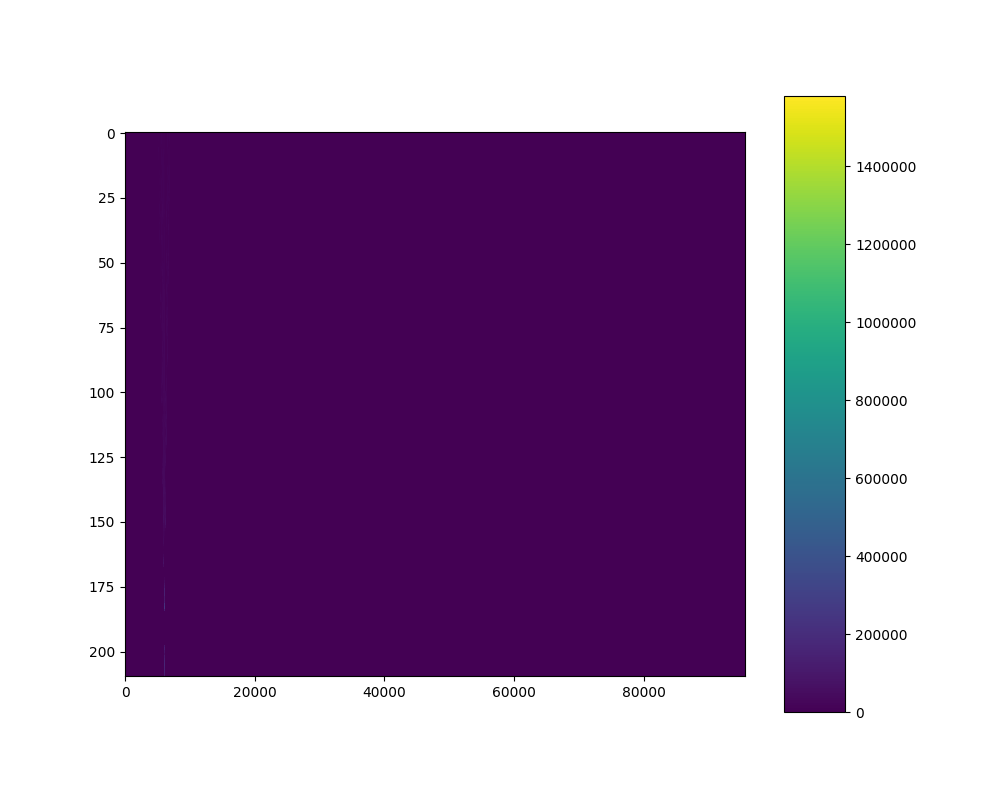

In [31]:
from matplotlib import pyplot
%matplotlib notebook
pyplot.figure(figsize=(10, 8))
a = pyplot.imshow(hough, aspect = 400)
pyplot.colorbar(shrink = 1,aspect = 10)
pyplot.sh
#DA METTER IN LOG
#integrazione fatta con numpy viene uguale a quella fatta con tf

In [ ]:



#print(candidati.nonzero)
#opzioni di sessione per profiling
#sessione = tf.Session(config=tf.ConfigProto(log_device_placement=True))
#run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
#run_metadata = tf.RunMetadata()

#calcolo

#%time houghs = sessione.run(houghmaps, options=run_options, run_metadata=run_metadata)




# Create the Timeline object, and write it to a json
#tl = timeline.Timeline(run_metadata.step_stats)
#ctf = tl.generate_chrome_trace_format()
#with open('timelinedopp.json', 'w') as f:
#	f.write(ctf)

    
#print(houghs.nbytes/1e9)
#print(numpy.shape(houghs))

## HWI

In [26]:
#da qui si usa tensorflow
#definisco tutte le costanti necessarie
#PROVA
#da qui si usa tensorflow
#definisco tutte le costanti necessarie
tempiTF = tf.constant(tempi, dtype=tf.float64)
freqTF = tf.constant(frequenze, dtype=tf.float64)

velTF = tf.constant(veloc, dtype=tf.float64)
quadTF = tf.constant(quadrato, dtype=tf.float64)

pesiTF = tf.constant(pesi,dtype=tf.float32)

spindownsTF = tf.constant(spindowns, dtype=tf.float32) 

#nPunti = tf.constant(numpy.shape(quadrato)[0], dtype=tf.int32)

tempiDC = tempiTF - primoTempo
tempiUnici, indiciUniciRipetuti, conteggi = tf.unique_with_counts(tempiDC)
indiciUnici = tf.cumsum(tf.pad(tf.unique_with_counts(indiciUniciRipetuti)[2],[[1,0]]))[:-1]

#qui cerco tutti i salti temporali vedendo quando tra un elemento e l'altro 
#c'è una differenza maggiore (un multiplo) dello step minimo
nIndici = tf.size(tempiUnici)-1
differenze = tempiUnici[1:nIndici+1]-tempiUnici[0:nIndici]

stepTempi = tf.reduce_min(differenze)
# il primo elemento nella peakmap è a tempi successivi del primo elemento delle velocità
tempiPrima = tf.reduce_min(tempiUnici)/stepTempi
tempiPrima = tf.cast(tempiPrima, dtype=tf.int64)
# vedo dove sono i salti
stepSaltati = differenze/stepTempi
stepSaltati = tf.cast(stepSaltati, dtype=tf.int64)

# ora seleziono solo gli indici dell'array di velocità
# ai quali il relativo step temporale ha frequenze non nulle nella peakmap

indiciVel = tf.zeros([tf.size(tempiUnici)-1],dtype=tf.int64) + tempiPrima
indiciVel = indiciVel + tf.cumsum(stepSaltati)
indiciVel = tf.concat([[tempiPrima], indiciVel],0)

freqTF = tf.map_fn(doppcorr, tf.range(0, nPunti-1), dtype=tf.float32, parallel_iterations=8)

tempiHM = tempiTF-epoca
tempiHM = ((tempiHM)*3600*24/stepFreqRaffinato)
tempiHM = tf.cast(tempiHM, tf.float32)

pesiHM = tf.reshape(pesiTF,(1,tf.size(pesiTF)))
pesiHM = pesiHM[0]

nRows = tf.constant(nstepSpindown, dtype=tf.int32)
#problema! num step freq cambia a seconda della correzione doppler
#perché freq min e freq max possono variare e lo step lo si lascia uguale
#posso andarci in 2 modi: uno è tagliando a 96000 tutto
#uno è mettendo un po' di zeri prima e dopo, cercando con la doppler corr quale è la max assoluta
#e quale è la min assoluta
#nColumns = tf.cast(nstepFrequenze, dtype=tf.int32)
nColumns = tf.cast(nstepsFreq, dtype=tf.int32)

#mettere un for
start = time.time()
for punto in numpy.arange(0,nPunti-1):
    houghmap = inDaHough(punto)
    hough = sessione.run(houghmap)
    freqStart = hough[1]
    hough = hough[0]
    candidati = manchurian_candidates(cands, freqStart, hough, patch[punto])
    nonzeri = numpy.nonzero(candidati[0])
    finalCand = candidati[:,nonzeri]
    #print(finalCand)
stop = time.time()
print(stop-start)

(1, 5)
97492.0
210
191


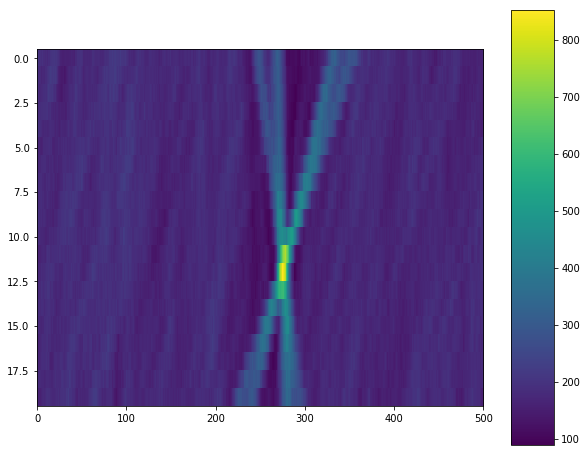

In [25]:
from matplotlib import pyplot
%matplotlib inline
pyplot.figure(figsize=(10, 8))
a = pyplot.imshow(hough[180:200,73000:73500], aspect = 20)
pyplot.colorbar(shrink = 1,aspect = 10)
#DA METTER IN LOG
#integrazione fatta con numpy viene uguale a quella fatta con tf

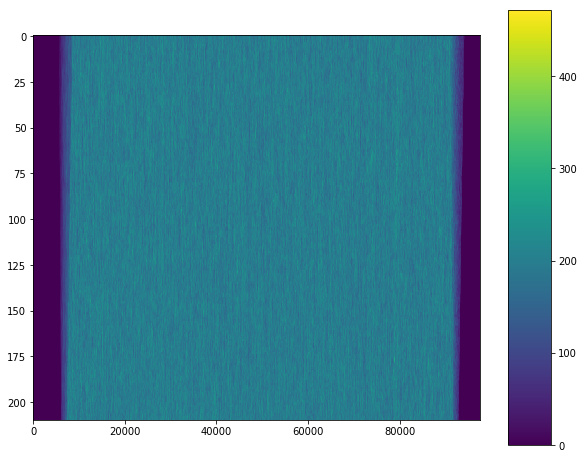

In [27]:
from matplotlib import pyplot
%matplotlib inline
pyplot.figure(figsize=(10, 8))
a = pyplot.imshow(hough, aspect = 400)
pyplot.colorbar(shrink = 1,aspect = 10)
#DA METTER IN LOG
#integrazione fatta con numpy viene uguale a quella fatta con tf

## mio cpu

* con slice
    10. 3.569532632827759

* con conv
    10. 6.6488728523254395

##  gpu wn100

* con slice
   10. 2.1228818893432617
* con conv
   10. 3.306060552597046


In [31]:
#CALCOLO SPINDONS

spindownMax = 1e-10
spindownMin = -1e-9
tFft = 8192
stepFreq = 1/tFft

tObs = 3.65#mesi
tObs = tObs*30*24*60*60
stepSDCustom = stepFreq/tObs 
stepSDCustom

nstepSpindownCustom = (spindownMax-spindownMin)/stepSDCustom# + stepSDCustom*85
print(nstepSpindownCustom)

spindownMax = 2e-9
spindownMin = -2e-9

tfft = 2048
stepFreq = 1/tfft

tObs = 4 #mesi
tObs = tObs*30*24*60*60
stepSDCustom = stepFreq/tObs 
stepSDCustom

(spindownMax-spindownMin)/stepSDCustom# + stepSDCustom*85

84.934656

In [42]:
#CALCOLO POSSIBILITÀ DI USARE PEAKMAP DENSA
tempiniu = (tempi - numpy.amin(tempi))
freqniu = (frequenze - numpy.amin(frequenze))
print(tempiniu, freqniu)

uniqtniu = numpy.unique(tempiniu)
sizetniu = numpy.size(uniqtniu)
stepstempi = uniqtniu[1:sizetniu]-uniqtniu[0:sizetniu-1]
print(numpy.amin(stepstempi), stepFreqRaffinato)

tempiniu = numpy.round(tempiniu*1e3).astype(numpy.int)
freqniu = numpy.round(freqniu*1e5).astype(numpy.int)
print(tempiniu, freqniu)
righe = numpy.amax(freqniu)
colonne = numpy.amax(tempiniu)
#se adattiva -> float32
print(righe, colonne)
nbytespeakdensa = 2*righe*colonne
nbytespeakdensa/1e9

[    0     0     0 ..., 22234 22234 22234] [   146    403    757 ..., 101050 101575 102063]


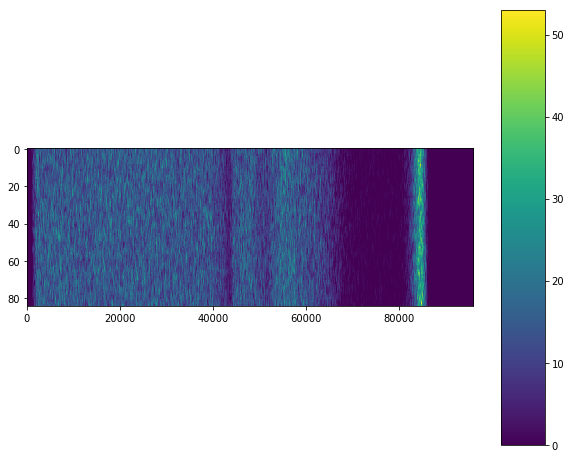

In [33]:
from matplotlib import pyplot
%matplotlib inline
pyplot.figure(figsize=(10, 8))
a = pyplot.imshow(houghs[8,:,:], aspect = 400)
pyplot.colorbar(shrink = 1,aspect = 10)
#DA METTER IN LOG
#integrazione fatta con numpy viene uguale a quella fatta con tf

### prove varie

In [18]:
#TODO STUDIARE FATTIBILITÀ DI USARE TUTTO A 32BYTES

def inDaHough(i):
    #metto per ora qui funzione che fa la hough per non dover passare variabili
    def houghizza(stepIesimo):
        sdTimed = tf.multiply(spindownsTF[stepIesimo], tempiHM, name = "Tdotpert")
        #sdTimed = tf.cast(sdTimed, dtype=tf.float32)
    
        appoggio = tf.round(freqHM-sdTimed+securbelt/2, name = "appoggioperindici")
        appoggio = tf.cast(appoggio, dtype=tf.int32)
    
        valori = tf.unsorted_segment_sum(pesiHM, appoggio, nColumns)

        return valori
    
    #per prima cosa faccia la correzione doppler per l'iesimo punto di cielo
    tempiDC = tempiTF - primoTempo
    tempiUnici, indiciUniciRipetuti, conteggi = tf.unique_with_counts(tempiDC)
    indiciUnici = tf.cumsum(tf.pad(tf.unique_with_counts(indiciUniciRipetuti)[2],[[1,0]]))[:-1]

    # qui va messa parte per calcolare i pesi, che per ora non mettiamo

    #qui faccio la doppl corr
    velPerPos = tf.matmul(tf.reshape(quadTF[i], [1,3]),velTF)
    velPerPos = velPerPos + 1
    velPerPos = velPerPos[0]

    #nel programma originale c'è un prodotto elementwise infattibile
    #(tra due array di diversa dimensione)
    # c'è anche un for che considera buchi di tempi dentro né prima

    #qui cerco tutti i salti temporali vedendo quando tra un elemento e l'altro 
    #c'è una differenza maggiore (un multiplo) dello step minimo
    nIndici = tf.size(tempiUnici)-1
    differenze = tempiUnici[1:nIndici+1]-tempiUnici[0:nIndici]

    stepTempi = tf.reduce_min(differenze)
    # il primo elemento nella peakmap è a tempi successivi del primo elemento delle velocità
    tempiPrima = tf.reduce_min(tempiUnici)/stepTempi
    tempiPrima = tf.cast(tempiPrima, dtype=tf.int64)
    # vedo dove sono i salti
    stepSaltati = differenze/stepTempi
    stepSaltati = tf.cast(stepSaltati, dtype=tf.int64)

    # ora seleziono solo gli indici dell'array di velocità
    # ai quali il relativo step temporale ha frequenze non nulle nella peakmap

    indiciVel = tf.zeros([tf.size(tempiUnici)-1],dtype=tf.int64) + tempiPrima
    indiciVel = indiciVel + tf.cumsum(stepSaltati)
    indiciVel = tf.concat([[tempiPrima], indiciVel],0)
    # e quindi definisco un nuovo array di velocità con i soli i valori
    # che mi interessano
    velUtili = tf.gather(velPerPos, indiciVel)

    #infine faccio la divisione e quindi ho le frequenze corrette
    freqCorr = freqTF/tf.gather_nd(velUtili,indiciUniciRipetuti[:,None])
    
    #mi ricavo l'header per le frequenze
    freqMin = tf.reduce_min(freqCorr)
    freqMax = tf.reduce_max(freqCorr)
    freqIniz = freqMin- stepFreq/2 - stepFreqRaffinato
    freqFin = freqMax + stepFreq/2 + stepFreqRaffinato
    nstepFrequenze = tf.ceil((freqFin-freqIniz)/stepFreqRaffinato)+securbelt

    # riarrangio gli array in modo che abbia i dati 
    # nel formato che voglio io
    freqCorr = freqCorr-freqIniz
    freqCorr = (freqCorr/stepFreqRaffinato)-round(enhancement/2+0.001)
    
#freqTF, nstepFrequenze = dopplerCorr(0)
    freqHM = tf.cast(freqCorr, tf.float32)

    #un po' di manipolazioni per il calcolo della hough
    tempiHM = tempiTF-epoca
    tempiHM = ((tempiHM)*3600*24/stepFreqRaffinato)
    tempiHM = tf.cast(tempiHM, tf.float32)

    pesiHM = tf.reshape(pesiTF,(1,tf.size(pesiTF)))
    pesiHM = pesiHM[0]
    
    nRows = tf.constant(nstepSpindown, dtype=tf.int32)
    #problema! num step freq cambia a seconda della correzione doppler
    #perché freq min e freq max possono variare e lo step lo si lascia uguale
    #posso andarci in 2 modi: uno è tagliando a 96000 tutto
    #uno è mettendo un po' di zeri prima e dopo, cercando con la doppler corr quale è la max assoluta
    #e quale è la min assoluta
    #nColumns = tf.cast(nstepFrequenze, dtype=tf.int32)
    nColumns = tf.cast(96000, dtype=tf.int32)
    
    # faccio la hough (differenziale)
    houghDiff = tf.map_fn(houghizza, tf.range(0, nRows), dtype=tf.float32, parallel_iterations=8)

    #faccio integrazione finale    
    semiLarghezza = tf.round(enhancement/2+0.001)
    semiLarghezza = tf.cast(semiLarghezza, tf.int32)
    houghInt = houghDiff[:,semiLarghezza*2:nColumns]-houghDiff[:,0:nColumns - semiLarghezza*2]
    houghInt = tf.concat([houghDiff[:,0:semiLarghezza*2],houghInt],1)
    houghInt = tf.cumsum(houghInt, axis = 1)

    
    return houghInt


